<a href="https://colab.research.google.com/github/tbeers615/DeepLearningProjects/blob/TransferLearning/TransferLearningPart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow, Part 2: Fine-Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

## Creating Helper Functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-22 16:28:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-22 16:28:20 (54.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's Get Some Data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food).

> **Note**: If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want access to your helper functions.

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-05-22 16:28:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   263MB/s    in 0.6s    

2022-05-22 16:28:58 (263 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[6.99081650e+01 6.19081612e+01 2.29081631e+01]
   [6.67142868e+01 5.77142830e+01 1.87142849e+01]
   [5.60459213e+01 4.64030647e+01 7.61734724e+00]
   ...
   [8.68727112e+01 7.88727112e+01 3.98727074e+01]
   [8.40051193e+01 8.00051193e+01 3.50051155e+01]
   [8.46172714e+01 8.06172714e+01 3.56172752e+01]]

  [[6.72142868e+01 5.82142868e+01 1.92142868e+01]
   [6.54897919e+01 5.64897957e+01 1.74897938e+01]
   [5.53979607e+01 4.57551041e+01 6.96938896e+00]
   ...
   [6.81125107e+01 5.89696732e+01 2.05665493e+01]
   [9.17805862e+01 8.47805862e+01 4.27805862e+01]
   [8.79540863e+01 8.09540863e+01 3.69540825e+01]]

  [[6.18469391e+01 5.12040825e+01 1.54183674e+01]
   [5.39693871e+01 4.33265305e+01 7.54081631e+00]
   [5.93418350e+01 4.81938782e+01 1.25765314e+01]
   ...
   [5.42856293e+01 4.39234543e+01 5.94888306e+00]
   [8.37603149e+01 7.41174622e+01 3.33317451e+01]
   [8.95713272e+01 7.99284668e+01 3.91427536e+01]]

  ...

  [[1.63852585e+02 1.62143448e+02 1.44924088e+02]
   [1

## Model 0: Building a Transfer Learning Feature Extraction Model Using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional

In [ ]:
# 1. Create base model with tf.keras.applications (not including top layer since ours is a different shape)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reducing number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile our model
model_0.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history = model_0.fit(train_data_10_percent,
                      batch_size=BATCH_SIZE,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.25 * len(test_data)),
                      callbacks=[create_tensorboard_callback(dir_name="Transfer_Learning",
                                                             experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: Transfer_Learning/10_percent_feature_extraction/20220522-162946
Epoch 1/5
24/24 [==============================] - 22s 232ms/step - loss: 1.9340 - accuracy: 0.3600 - val_loss: 1.3634 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 4s 152ms/step - loss: 1.1697 - accuracy: 0.7320 - val_loss: 0.9271 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 4s 148ms/step - loss: 0.8485 - accuracy: 0.8040 - val_loss: 0.7682 - val_accuracy: 0.8026
Epoch 4/5
24/24 [==============================] - 5s 182ms/step - loss: 0.6912 - accuracy: 0.8493 - val_loss: 0.6791 - val_accuracy: 0.8076
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5985 - accuracy: 0.8653 - val_loss: 0.6324 - val_accuracy: 0.8191


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6089 - accuracy: 0.8412


[0.6088958978652954, 0.8411999940872192]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about a summary of our model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


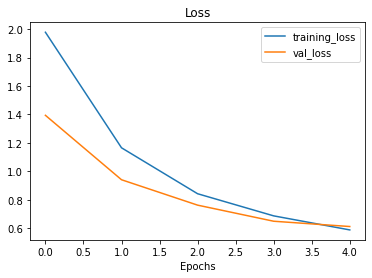

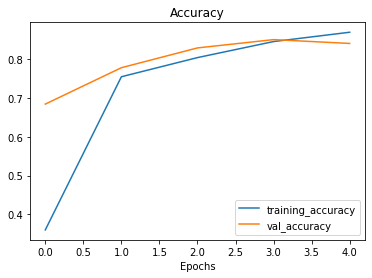

In [ ]:
# Check out our model's training curves
plot_loss_curves(history)

## Getting a Feature Vector From a Trained Model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Practice** Try to recreate the same two cells above, but this time use `GlobalMaxPool2D` and see what happens.

**Note**: One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be used to extract patterns out of for our own specific problem.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 3)


## Running a Series of Transfer Learning Experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data? How about we set up a bunch of experiments to find out:

1. `model_1` - Use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - Use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - Use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - Use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** Throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency across evaluation metrics.

In [ ]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-05-22 16:30:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.134.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.134.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   236MB/s    in 0.5s    

2022-05-22 16:30:52 (236 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [ ]:
# Setup data loaders
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation Right Into the Model
To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of our heads, after reading the docs, the benefits of using the data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal, flipping, rotations, zooms, etc.
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet has it built in
  ], name="data_augmentation")

### Visualize Our Data Augmentation Layer (and see what happens to our data)

(-0.5, 556.5, 432.5, -0.5)

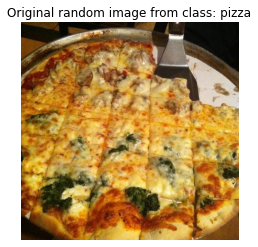

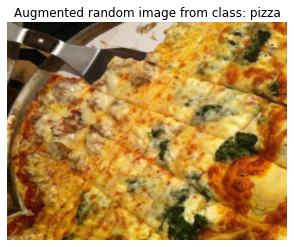

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(augmented_img/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [ ]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Model 1: Feature Extraction Transfer Learning on 1% of the Data With Data Augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs, training=True)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220522-163108
Epoch 1/5
3/3 [==============================] - 19s 6s/step - loss: 2.3944 - accuracy: 0.1143 - val_loss: 2.2506 - val_accuracy: 0.1447
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1419 - accuracy: 0.2857 - val_loss: 2.1293 - val_accuracy: 0.2188
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 1.9992 - accuracy: 0.3857 - val_loss: 2.0326 - val_accuracy: 0.2911
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.8095 - accuracy: 0.4714 - val_loss: 1.9554 - val_accuracy: 0.3536
Epoch 5/5
3/3 [==============================] - ETA: 0s - loss: 1.6370 - accuracy: 0.6000

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the test data set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 20s 238ms/step - loss: 1.8675 - accuracy: 0.4116


[1.8674885034561157, 0.4115999937057495]

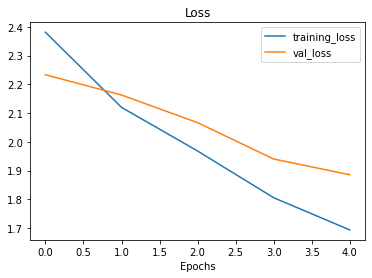

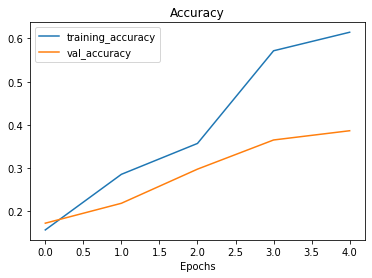

In [ ]:
plot_loss_curves(history_1_percent)

In [ ]:
# 1. Create base model with tf.keras.applications (not including top layer since ours is a different shape)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

input_shape = (224,224,3)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

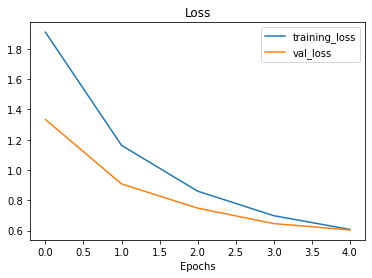

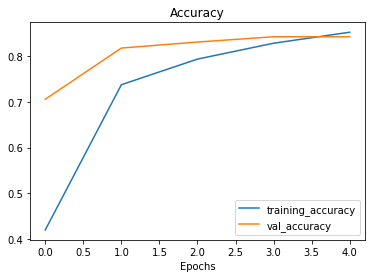

In [ ]:
plot_loss_curves(history2)

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 72ms/step - loss: 2.4982 - accuracy: 0.0644


[2.49815034866333, 0.06440000236034393]

### Creating a ModelCheckpoint Callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is usesful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose = 1)

### Fit model 2 passing in the ModelCheckpoint callback

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220522-163343
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0198 - accuracy: 0.3320
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 414ms/step - loss: 2.0198 - accuracy: 0.3320 - val_loss: 1.5385 - val_accuracy: 0.5954
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.6387
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 331ms/step - loss: 1.3831 - accuracy: 0.6387 - val_loss: 1.1022 - val_accuracy: 0.7368
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0670 - accuracy: 0.7373
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 305ms/step - loss: 1.0670 - accuracy: 0.7373 - val_loss: 0.9091 - val_accuracy: 0.7582
Epo

In [ ]:
# Check model_2 results on all test_data

results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 0.6940 - accuracy: 0.8128


[0.6940091252326965, 0.8127999901771545]

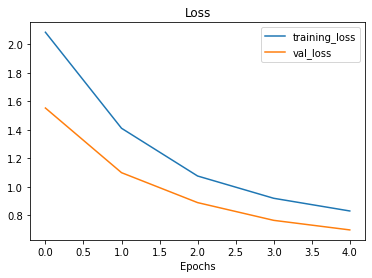

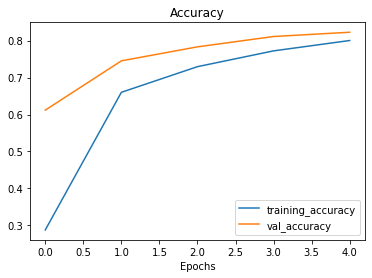

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in Checkpointed Weights

Loading in checkpointed weights returns a model to a specified checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.6940 - accuracy: 0.8128


In [ ]:
# If the results from our previously evaluated model 2 match the loaded weights, everything has worked
results_10_percent_data_aug==loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6940091252326965, 0.8127999901771545]

In [ ]:
loaded_weights_model_results

[0.6940093040466309, 0.8127999901771545]

In [ ]:
# Check to see if the loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

### Model 3: Fine-tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with a large amount of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f87ee6cd950> True
<keras.engine.sequential.Sequential object at 0x7f87ee6cdcd0> True
<keras.engine.functional.Functional object at 0x7f87c4ed6e90> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f87ee6cd090> True
<keras.layers.core.dense.Dense object at 0x7f87ee6cd4d0> True


In [ ]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(base_model.layers):
  print(i, layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # Start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220522-164520
Epoch 5/10
24/24 [==============================] - 18s 424ms/step - loss: 0.7696 - accuracy: 0.7413 - val_loss: 0.7107 - val_accuracy: 0.7500
Epoch 6/10
24/24 [==============================] - 9s 349ms/step - loss: 0.4119 - accuracy: 0.8587 - val_loss: 0.5634 - val_accuracy: 0.8043
Epoch 7/10
24/24 [==============================] - 7s 285ms/step - loss: 0.2698 - accuracy: 0.9120 - val_loss: 0.6211 - val_accuracy: 0.8026
Epoch 8/10
24/24 [==============================] - 8s 314ms/step - loss: 0.1993 - accuracy: 0.9400 - val_loss: 0.7512 - val_accuracy: 0.7681
Epoch 9/10
24/24 [==============================] - 8s 302ms/step - loss: 0.1457 - accuracy: 0.9547 - val_loss: 0.6074 - val_accuracy: 0.8125
Epoch 10/10
24/24 [==============================] - 8s 312ms/step - loss: 0.0912 - accuracy: 0.9787 - val_loss: 0.7115 - val_accuracy: 0.8076


In [ ]:
# Evaluate the fine-tuned model (model_3, which is model_2 fine-tuned for additional 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 10s 113ms/step - loss: 0.6176 - accuracy: 0.8288


In [ ]:
results_10_percent_data_aug

[0.6940091252326965, 0.8127999901771545]

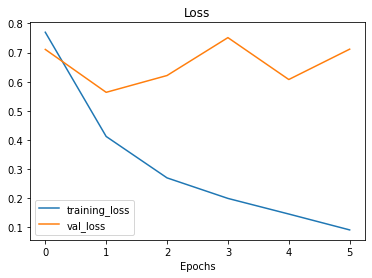

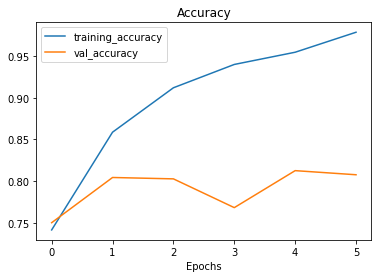

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

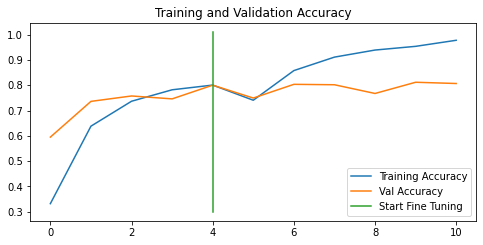

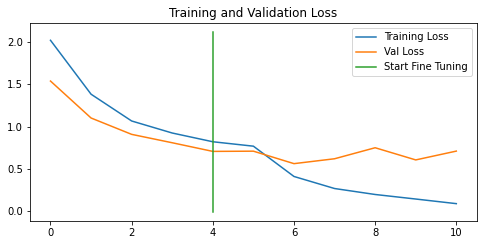

In [ ]:
import matplotlib.pyplot as plt
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an Existing Model on all of the Data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-05-22 17:04:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 172.253.123.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   167MB/s    in 3.0s    

2022-05-22 17:04:27 (167 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this...

In [ ]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6176 - accuracy: 0.8288


[0.6176411509513855, 0.8288000226020813]

In [ ]:
results_fine_tune_10_percent

[0.6176410913467407, 0.8288000226020813]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
# Load weights from checkpoint, that way we can
# fine-tune from the same stage the 10 percent data was fine-tuned from

model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now

model_2.evaluate(test_data)

79/79 [==============================] - 8s 93ms/step - loss: 0.6940 - accuracy: 0.8128


[0.6940094232559204, 0.8127999901771545]

In [ ]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6940091252326965, 0.8127999901771545]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top ten layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2, except this time we're going to use all of the data (model_4).

In [ ]:
# Check which layers are tunable in the whole modle
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full_10_classes_fine_tune_1a")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_1a/20220522-172658
Epoch 5/10
235/235 [==============================] - 58s 219ms/step - loss: 0.7282 - accuracy: 0.7629 - val_loss: 0.3655 - val_accuracy: 0.8750
Epoch 6/10
235/235 [==============================] - 46s 193ms/step - loss: 0.5784 - accuracy: 0.8180 - val_loss: 0.3918 - val_accuracy: 0.8684
Epoch 7/10
235/235 [==============================] - 40s 170ms/step - loss: 0.5375 - accuracy: 0.8264 - val_loss: 0.3636 - val_accuracy: 0.8783
Epoch 8/10
235/235 [==============================] - 39s 163ms/step - loss: 0.4916 - accuracy: 0.8396 - val_loss: 0.3200 - val_accuracy: 0.8783
Epoch 9/10
235/235 [==============================] - 37s 154ms/step - loss: 0.4524 - accuracy: 0.8532 - val_loss: 0.3167 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 36s 153ms/step - loss: 0.4107 - accuracy: 0.8677 - val_loss: 0.3160 - val_accuracy: 0.9013


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 80ms/step - loss: 0.2986 - accuracy: 0.9068


[0.29864174127578735, 0.9067999720573425]

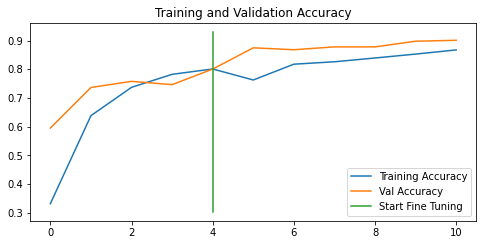

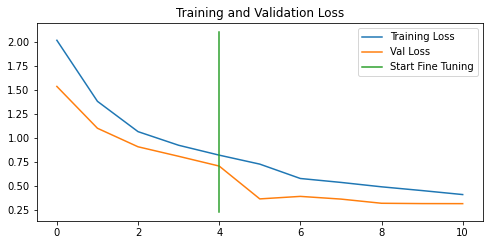

In [ ]:
# How did fine-tuning go with more details
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)

## Viewing our experiment data on TensorBoard

> **Note**: Anything you upload on TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should -4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once its finished uploading \

My TensorBoard experiments are available here: https://tensorboard.dev/experiment/x4edQxwGQFGCG3beRpmxEQ/#scalars

In [ ]:
# View all of your uploaded TensorBoard.dev experiments (public)
# ! tensorboard dev list

In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id #here is where you would enter the ID